In [1]:
import random
import torch
import scvi
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(dpi=100, frameon=False, color_map='Reds', facecolor=None)
sc.logging.print_header()

Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


scanpy==1.9.1 anndata==0.7.6 umap==0.5.3 numpy==1.19.4 scipy==1.6.2 pandas==1.3.3 scikit-learn==0.23.2 statsmodels==0.11.1 pynndescent==0.5.5


/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/umap/__init__.py:11: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  category=ImportWarning,


## Data

Dataset curation at https://github.com/theislab/sc-pert/blob/main/datasets/Norman_2019.ipynb

In [2]:
adata = sc.read('/storage/groups/ml01/workspace/yuge.ji/sc-pert/datasets/Norman_2019.h5ad')
adata

AnnData object with n_obs × n_vars = 111255 × 19018
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', '

TODO: add Schraivogel if things work out.

Subset to singletons to simplify the problem without much data loss.

In [3]:
adata = adata[adata.obs.perturbation_name.isin(
    [x for x in adata.obs.perturbation_name.value_counts().index if '+' not in x])]
adata.shape

(69570, 19018)

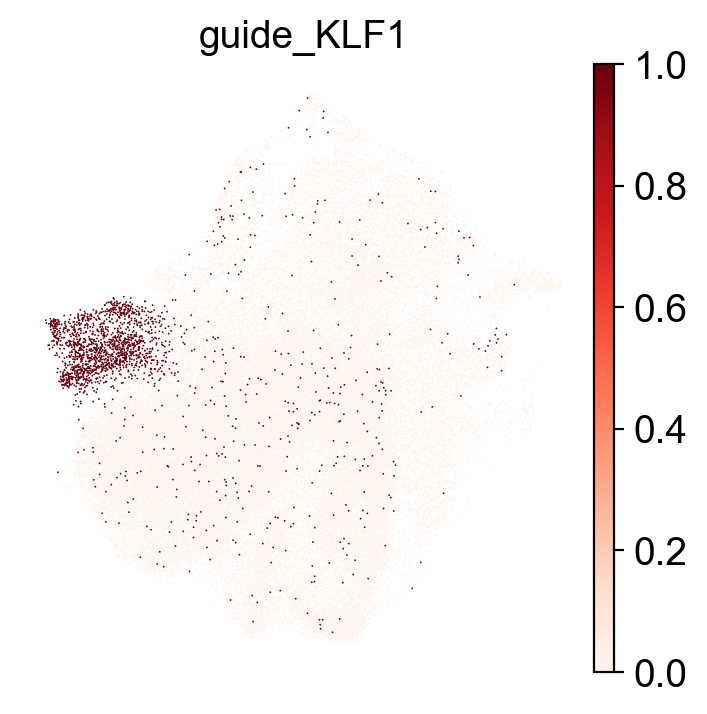

In [4]:
sc.pl.umap(adata, color=['guide_KLF1'], cmap='Reds')

In [5]:
sound_labels = adata.obs.perturbation_name.value_counts()[adata.obs.perturbation_name.value_counts() > 100].index
adata = adata[adata.obs.perturbation_name.isin(sound_labels)].copy()
len(sound_labels)

106

Now let's look at the guides with no overlap with var_names. Since we can't use these samples for feature attribution, we'll use a portion of them as a test set.

In [7]:
missing_var = set(sound_labels) - set(adata.var_names) - set(['control'])
missing_var

{'C19orf26', 'C3orf72', 'KIAA1804'}

In [8]:
test_indices = random.sample(set(adata[adata.obs.perturbation_name.isin(missing_var)].obs.index), 400)
adata.obs['split'] = 'train'
adata.obs['split'][test_indices] = 'test'
adata.obs['split'] = adata.obs['split'].astype('category')

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


TODO: save this filtered dataset in a SHARED workspace directory

In [16]:
adata.write('../datasets/scgen_norman19.h5ad')

/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'split' as categorical


## Train

In [9]:
import scgen

In [13]:
# example: scgen.SCGEN.setup_anndata(train_new, batch_key="condition", labels_key="cell_type")
scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')

In [14]:
# instantiate a model to get a preview
model = scgen.SCGEN(adata)
model.module

SCGENVAE(
  (z_encoder): Encoder(
    (encoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequential(
          (0): Linear(in_features=19018, out_features=800, bias=True)
          (1): BatchNorm1d(800, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
        (Layer 1): Sequential(
          (0): Linear(in_features=800, out_features=800, bias=True)
          (1): BatchNorm1d(800, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): LeakyReLU(negative_slope=0.01)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=800, out_features=100, bias=True)
    (var_encoder): Linear(in_features=800, out_features=100, bias=True)
  )
  (decoder): DecoderSCGEN(
    (decoder): FCLayers(
      (fc_layers): Sequential(
        (Layer 0): Sequentia

Parameters taken from the scGen tutorial.

In [15]:
torch.cuda.is_available()

True

In [ ]:
def train_model(data, i, save_model_as):
    model = scgen.SCGEN(data)
    model.train(
        max_epochs=100,
        batch_size=32,
        early_stopping=True,
        early_stopping_patience=25
    )
    model.save(save_model_as, overwrite=True)
    # plot performance
    pd.concat(model.history.values(), axis=1).plot()
    plt.legend(bbox_to_anchor=(1.01, 1.05))
    plt.show()
    return model

n_runs=5
# run with different seeds
for i in range(n_runs):
    scvi.settings.seed = i
    _ = train_model(adata, i, f"../models/scgen_norman19_model{i}_random")

# run with shuffled data
for i in range(n_runs):
    indices = list(range(adata.shape[0]))
    random.Random(i).shuffle(indices)
    adata = adata[indices].copy()
    scgen.SCGEN.setup_anndata(adata, batch_key='perturbation_name')
    _ = train_model(adata, i, f"../models/scgen_norman19_model{i}_shuffled")

Global seed set to 0
/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (ElboMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, u

Epoch 7/100:   6%|██████████▉                                                                                                                                                                            | 6/100 [03:24<45:55, 29.32s/it, loss=430, v_num=1]

TODO: make sure models are truly different

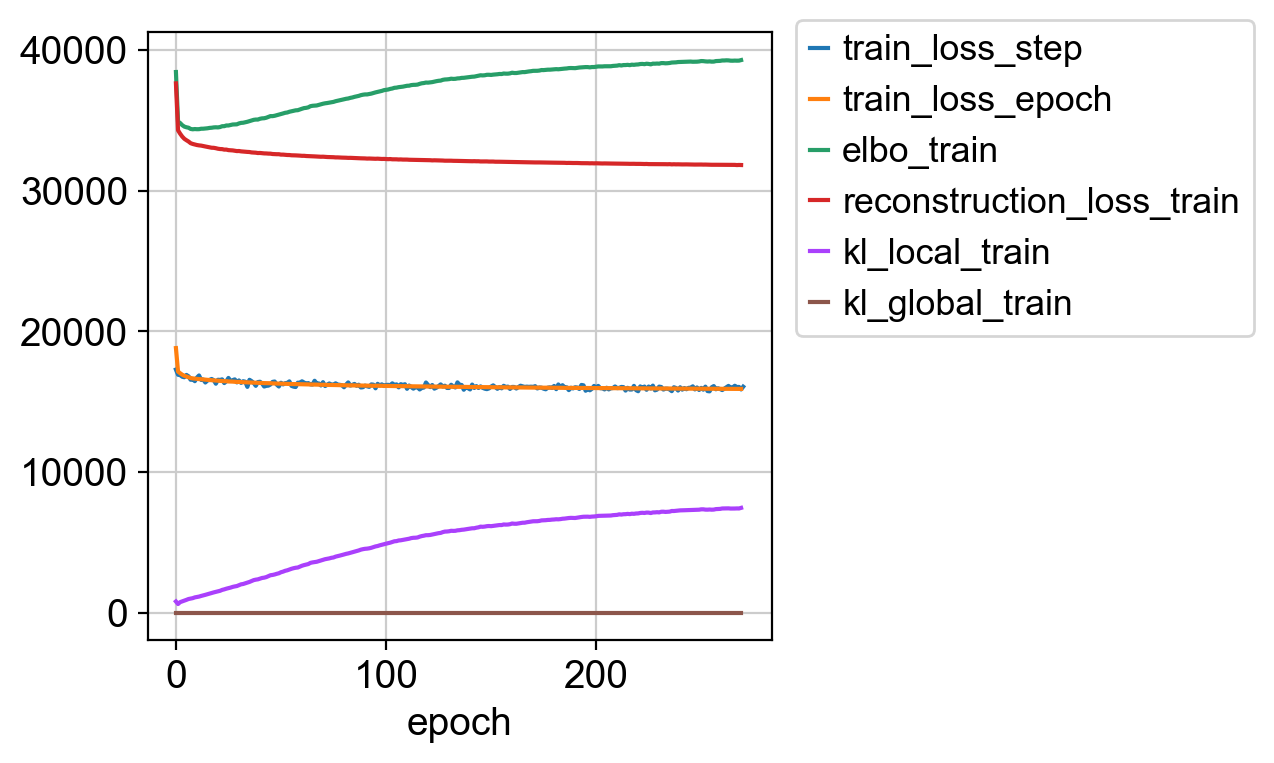

In [58]:
# # plot the very last one to check
# pd.concat(_.history.values(), axis=1).plot()
# plt.legend(bbox_to_anchor=(1.01, 1.05));

## Quality control

potential todo: loop over multiple models here.

We'll start off with latent space visualization. This should have the same if not more structure than the original UMAP.

In [15]:
latent_X = model.get_latent_representation()
latent_adata = sc.AnnData(X=latent_X, obs=adata.obs.copy())

In [16]:
latent_adata

AnnData object with n_obs × n_vars = 69570 × 100
    obs: 'guide_identity', 'read_count', 'UMI_count', 'coverage', 'gemgroup', 'good_coverage', 'number_of_cells', 'guide_AHR', 'guide_ARID1A', 'guide_ARRDC3', 'guide_ATL1', 'guide_BAK1', 'guide_BCL2L11', 'guide_BCORL1', 'guide_BPGM', 'guide_C19orf26', 'guide_C3orf72', 'guide_CBFA2T3', 'guide_CBL', 'guide_CDKN1A', 'guide_CDKN1B', 'guide_CDKN1C', 'guide_CEBPA', 'guide_CEBPB', 'guide_CEBPE', 'guide_CELF2', 'guide_CITED1', 'guide_CKS1B', 'guide_CLDN6', 'guide_CNN1', 'guide_CNNM4', 'guide_COL1A1', 'guide_COL2A1', 'guide_CSRNP1', 'guide_DLX2', 'guide_DUSP9', 'guide_EGR1', 'guide_ELMSAN1', 'guide_ETS2', 'guide_FEV', 'guide_FOSB', 'guide_FOXA1', 'guide_FOXA3', 'guide_FOXF1', 'guide_FOXL2', 'guide_FOXO4', 'guide_GLB1L2', 'guide_HES7', 'guide_HK2', 'guide_HNF4A', 'guide_HOXA13', 'guide_HOXB9', 'guide_HOXC13', 'guide_IER5L', 'guide_IGDCC3', 'guide_IKZF3', 'guide_IRF1', 'guide_ISL2', 'guide_JUN', 'guide_KIAA1804', 'guide_KIF18B', 'guide_KIF2C', 'gui

In [17]:
%%time
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/yuge.ji/miniconda3/envs/py37_fa_train2/lib/python3.7/site-packages/umap/spectral.py:349: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


CPU times: user 1min 51s, sys: 13.5 s, total: 2min 4s
Wall time: 1min 34s


In [18]:
adata.obs.perturbation_name.value_counts().head(5)

control    11835
KLF1        1954
BAK1        1451
CEBPE       1230
ETS2        1201
Name: perturbation_name, dtype: int64

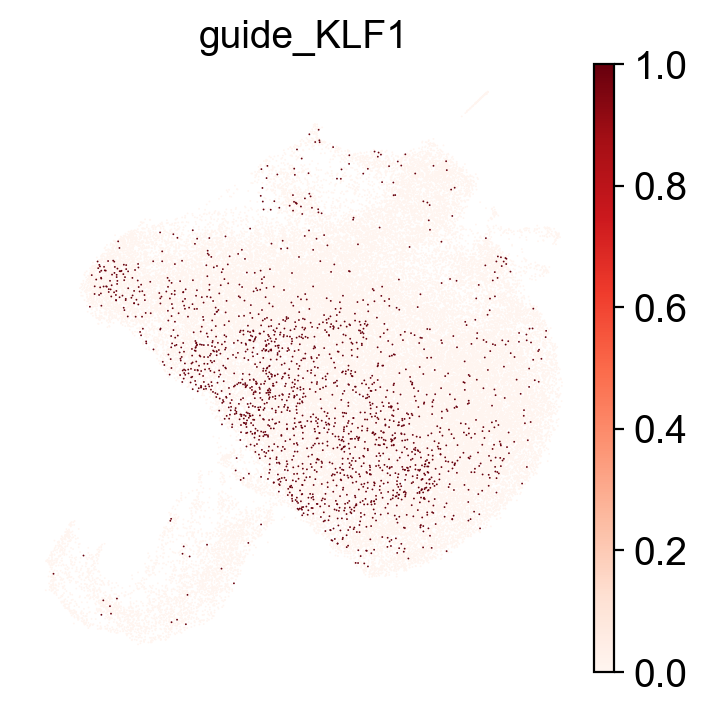

In [19]:
sc.pl.umap(latent_adata, color=['guide_KLF1'], cmap='Reds')

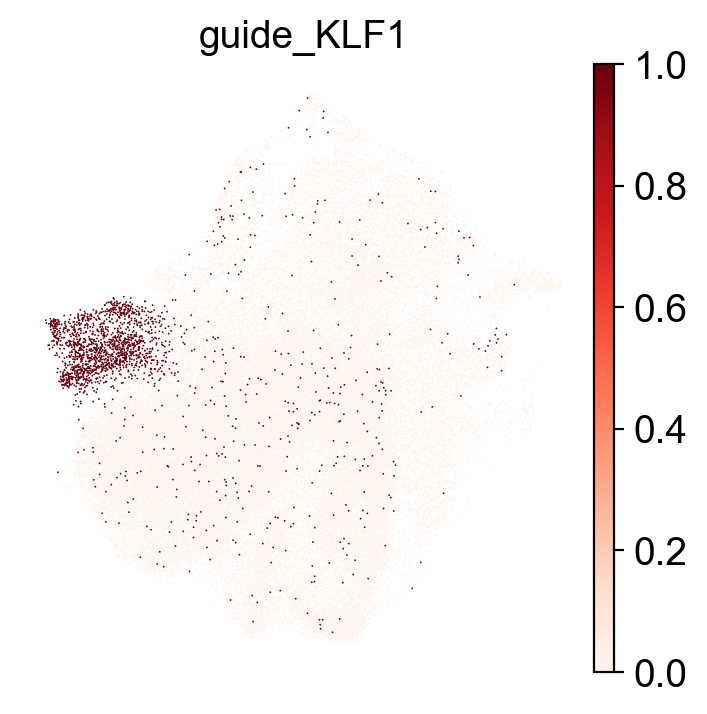

In [20]:
sc.pl.umap(adata, color=['guide_KLF1'], cmap='Reds')

### Mean correlations

(Standard evaluation metrics, but no test set.)

In [21]:
example_pert = 'KLF1'  # condition with the most occurrences

TODO: run the full 30min diffexp when you have time

In [ ]:
ctrl_adata = adata[adata.obs.perturbation_name.isin(['control', example_pert])]

sc.tl.rank_genes_groups(ctrl_adata, groupby='perturbation_name', reference='control', method='wilcoxon')

In [22]:
diff_genes = ctrl_adata.uns['rank_genes_groups']['names'][example_pert]
print(diff_genes[:10])

Trying to set attribute `.uns` of view, copying.


['TMSB10' 'HBZ' 'PNMT' 'KLF1' 'HBG2' 'HBA1' 'HBG1' 'EMP3' 'ANXA2' 'BLVRB']


In [24]:
pred, delta = model.predict(
    ctrl_key='control',
    stim_key=example_pert,
    adata_to_predict=adata[adata.obs.perturbation_name == 'control'].copy()  # strange implementation but ok
)
pred.obs['perturbation_name'] = 'pred'

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  


In [25]:
eval_adata = pred.concatenate(ctrl_adata)[:, diff_genes[:100]]

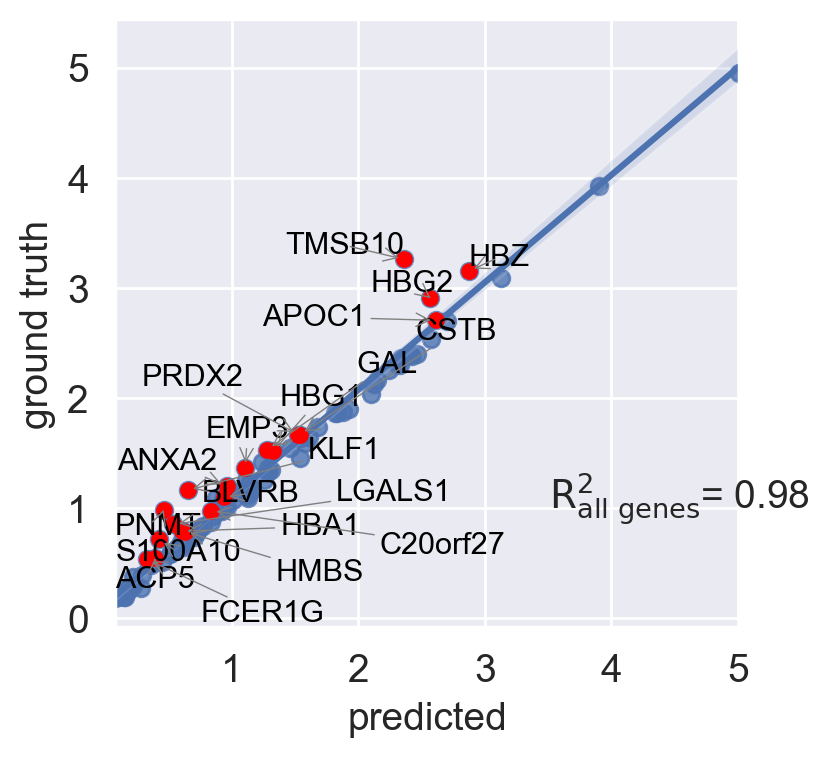

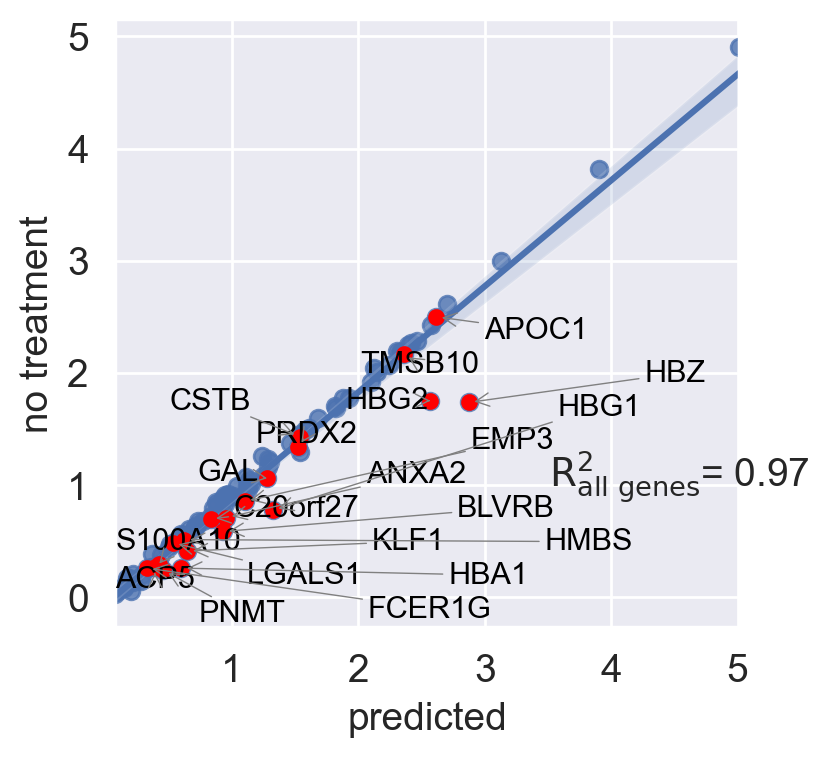

In [26]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': example_pert},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'ground truth'},
    show=True,
    legend=False
)
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': 'pred', 'y': 'control'},
    gene_list=diff_genes[:20],
    labels={'x': 'predicted', 'y': 'no treatment'},
    show=True,
    legend=False
)

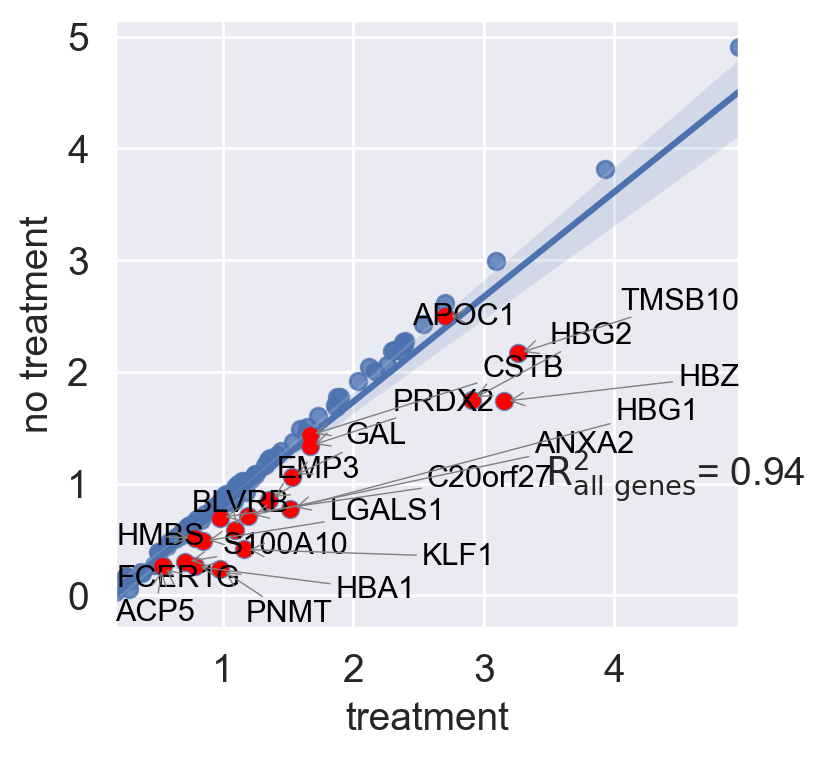

In [27]:
r2_value = model.reg_mean_plot(
    eval_adata,
    axis_keys={'x': example_pert, 'y': 'control'},
    gene_list=diff_genes[:20],
    labels={'x': 'treatment', 'y': 'no treatment'},
    show=True,
    legend=False
)

This is exactly the trend in performance we'd expect, and with not that many epochs.

TODO: loop over all conditions to get an overall score